In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import re

# Aperture fix

In [200]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta3.json')
tw = line.twiss()
tt = line.get_table()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


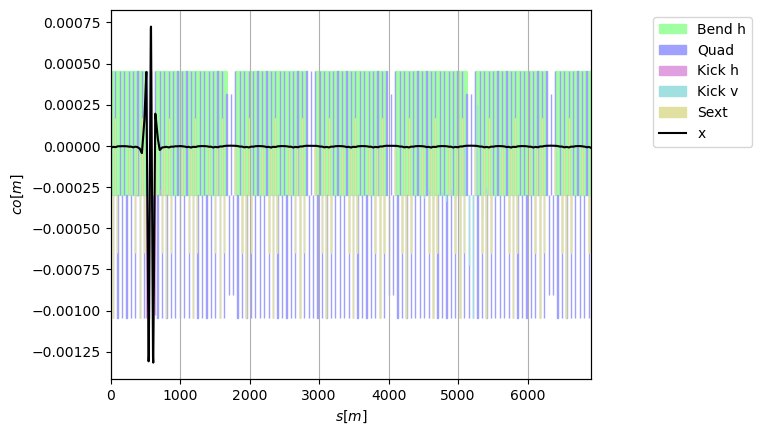

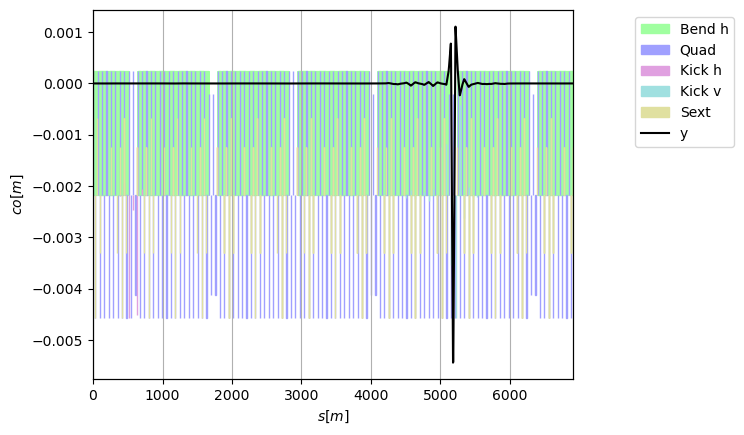

In [201]:
tw.plot('x')
tw.plot('y')
plt.show()

In [202]:
def move_list_element_n_backwards(lst, elems, n):
    for elem in elems:
        idx = lst.index(elem)
        if idx < n or idx >= len(lst):
            raise IndexError(f'Index {idx} of element {elem} out of valid range for moving back {n} steps.')

        elem_check = lst.pop(idx)
        assert elem == elem_check
        lst.insert(idx-n, elem)
    return lst

## Step 1: putting apertures at right location

In [203]:
base_names = np.array([re.match(r'^[^.]+\.\d+', s).group() for s in tt.rows['.*bp.*'].name ])

from collections import defaultdict

required_suffixes = {'..0', '..1', '..2', '.a_aper', '.b_aper'}

bpm_dict = defaultdict(set)
for full, base in zip(tt.rows['.*bp.*'].name, base_names):
    suffix = full.replace(base, '')
    bpm_dict[base].add(suffix)

bpms = np.array([str(base) for base, suffixes in bpm_dict.items()
                 if required_suffixes.issubset(suffixes)])

In [204]:
line.discard_tracker()
lst = list(line.element_names)
elems=['tidp.11434.a_aper', 'tidp.11434..2', 'tcsm.51932.a_aper', 'tcsm.51932..2']
n=1
line.element_names = tuple(move_list_element_n_backwards(lst, elems, n))

line.discard_tracker()
lst = list(line.element_names)
elems = [f'{name}{suffix}' for name in bpms for suffix in ('.a_aper', '..2')]
n=1
line.element_names = tuple(move_list_element_n_backwards(lst, elems, n))

In [205]:
tt.rows['.*bpce.*']

Table: 39 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
bpce.11906.a_aper       606.955 LimitEllipse   False     False None               False
bpce.11906              607.064 Drift           True     False None               False
bpce.11906.b_aper       607.354 LimitEllipse   False     False None               False
bpce.21604.a_aper       1662.42 LimitEllipse   False     False None               False
bpce.21604              1662.53 Drift           True     False None               False
bpce.21604.b_aper       1662.82 LimitEllipse   False     False None               False
bpce.21706.a_aper       1694.76 LimitEllipse   False     False None               False
bpce.21706              1694.87 Drift           True     False None               False
bpce.21706.b_aper       1695.16 LimitEllipse   False     False None               False
bpce.21803.a_aper       1726.23 LimitEllipse   False     False None               False
...


In [206]:
tt2 = line.get_table()

In [207]:
tt2.rows['.*bp.*']

Table: 1128 rows, 11 cols
name                         s element_type isthick isreplica parent_name iscollective ...
bpv.10108.a_aper       31.6277 LimitRect      False     False None               False
bpv.10108..0           31.6277 DriftSlice      True     False bpv.10108          False
bpv.10108..1           31.6283 DriftSlice      True     False bpv.10108          False
bpv.10108..2           31.9021 DriftSlice      True     False bpv.10108          False
bpv.10108.b_aper       31.9027 LimitRect      False     False None               False
bph.10208.a_aper       63.6254 LimitRect      False     False None               False
bph.10208..0           63.6254 DriftSlice      True     False bph.10208          False
bph.10208..1            63.626 DriftSlice      True     False bph.10208          False
bph.10208..2           63.8998 DriftSlice      True     False bph.10208          False
bph.10208.b_aper       63.9004 LimitRect      False     False None               False
...
bpv.63508

seems to be moved correctly

## Step 2: merge the drifs and replace by the parent drift

In [208]:
newline = xt.Line(elements=[], element_names=[])

for ii, (ee, nn) in enumerate(zip(line.elements, line.element_names)):
    if nn[:2]=='bp':
        print(nn)
        nn_base = re.match(r'^[^.]+\.\d+', nn).group()
        if nn_base in bpms:
            if 'a_aper' in nn or 'b_aper' in nn:
                newline.append_element(ee, nn)
            elif '..0' in nn:
                newline.append_element(xt.Drift(length=ee._parent.length), nn_base)
            else:
                pass
    elif nn[:4]=='tcsm' or nn[:4]=='tidp':
        nn_base = re.match(r'^[^.]+\.\d+', nn).group()
        if 'a_aper' in nn or 'b_aper' in nn:
                newline.append_element(ee, nn)
                print(newline.element_names[-1])
        elif '..0' in nn:
            newline.append_element(xt.Drift(length=ee._parent.length), nn_base)
            print(newline.element_names[-1])
        else:
            pass
    else:
        newline.append_element(ee, nn)

bpv.10108.a_aper
bpv.10108..0
bpv.10108..1
bpv.10108..2
bpv.10108.b_aper
bph.10208.a_aper
bph.10208..0
bph.10208..1
bph.10208..2
bph.10208.b_aper
bpv.10308.a_aper
bpv.10308..0
bpv.10308..1
bpv.10308..2
bpv.10308.b_aper
bph.10408.a_aper
bph.10408..0
bph.10408..1
bph.10408..2
bph.10408.b_aper
bpv.10508.a_aper
bpv.10508..0
bpv.10508..1
bpv.10508..2
bpv.10508.b_aper
bph.10608.a_aper
bph.10608..0
bph.10608..1
bph.10608..2
bph.10608.b_aper
bpv.10708.a_aper
bpv.10708..0
bpv.10708..1
bpv.10708..2
bpv.10708.b_aper
bph.10808.a_aper
bph.10808..0
bph.10808..1
bph.10808..2
bph.10808.b_aper
bpv.10908.a_aper
bpv.10908..0
bpv.10908..1
bpv.10908..2
bpv.10908.b_aper
bph.11008.a_aper
bph.11008..0
bph.11008..1
bph.11008..2
bph.11008.b_aper
bpv.11108.a_aper
bpv.11108..0
bpv.11108..1
bpv.11108..2
bpv.11108.b_aper
bph.11208.a_aper
bph.11208..0
bph.11208..1
bph.11208..2
bph.11208.b_aper
bpv.11308.a_aper
bpv.11308..0
bpv.11308..1
bpv.11308..2
bpv.11308.b_aper
bph.11408.a_aper
bph.11408..0
bph.11408..1
bph.1140

In [ ]:
np.where(bpms=='bpcr.31202')

(array([83]),)

In [210]:
newline.element_names.index('bph.63608')

32533

In [212]:
for nn in newline.element_names:
    if nn[:2]=='bp':
        print(nn)

bpv.10108.a_aper
bpv.10108
bpv.10108.b_aper
bph.10208.a_aper
bph.10208
bph.10208.b_aper
bpv.10308.a_aper
bpv.10308
bpv.10308.b_aper
bph.10408.a_aper
bph.10408
bph.10408.b_aper
bpv.10508.a_aper
bpv.10508
bpv.10508.b_aper
bph.10608.a_aper
bph.10608
bph.10608.b_aper
bpv.10708.a_aper
bpv.10708
bpv.10708.b_aper
bph.10808.a_aper
bph.10808
bph.10808.b_aper
bpv.10908.a_aper
bpv.10908
bpv.10908.b_aper
bph.11008.a_aper
bph.11008
bph.11008.b_aper
bpv.11108.a_aper
bpv.11108
bpv.11108.b_aper
bph.11208.a_aper
bph.11208
bph.11208.b_aper
bpv.11308.a_aper
bpv.11308
bpv.11308.b_aper
bph.11408.a_aper
bph.11408
bph.11408.b_aper
bpv.11508.a_aper
bpv.11508
bpv.11508.b_aper
bph.11608.a_aper
bph.11608
bph.11608.b_aper
bpv.11706.a_aper
bpv.11706
bpv.11706.b_aper
bph.11831.a_aper
bph.11831
bph.11831.b_aper
bph.12008.a_aper
bph.12008
bph.12008.b_aper
bpv.12108.a_aper
bpv.12108
bpv.12108.b_aper
bpsh.12174.a_aper
bpsh.12174
bpsh.12174.b_aper
bpsv.12179.a_aper
bpsv.12179
bpsv.12179.b_aper
bph.12208.a_aper
bph.12208

In [213]:
line.discard_tracker()
line.element_names = newline.element_names
line.element_dict.update(newline.element_dict)

In [214]:
ttn = line.get_table()

In [215]:
ttn.rows['.*bp.*']

Table: 630 rows, 11 cols
name                         s element_type isthick isreplica parent_name iscollective ...
bpv.10108.a_aper       31.6277 LimitRect      False     False None               False
bpv.10108              31.6277 Drift           True     False None               False
bpv.10108.b_aper       31.9027 LimitRect      False     False None               False
bph.10208.a_aper       63.6254 LimitRect      False     False None               False
bph.10208              63.6254 Drift           True     False None               False
bph.10208.b_aper       63.9004 LimitRect      False     False None               False
bpv.10308.a_aper       95.6231 LimitRect      False     False None               False
bpv.10308              95.6231 Drift           True     False None               False
bpv.10308.b_aper       95.8981 LimitRect      False     False None               False
bph.10408.a_aper       127.621 LimitRect      False     False None               False
...
bpv.63308.

In [216]:
twn = line.twiss()

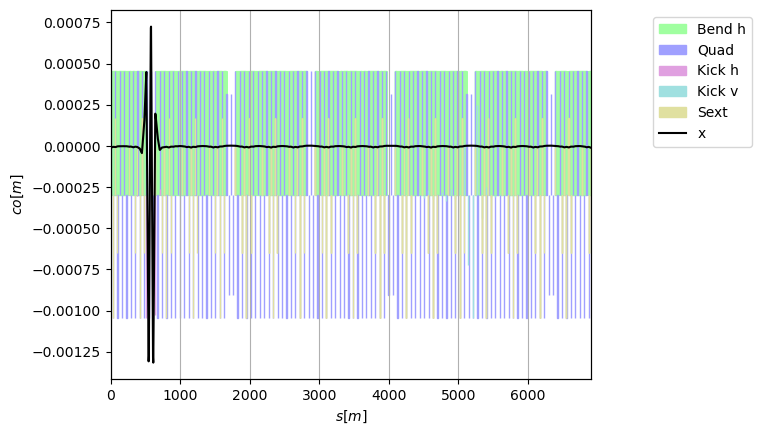

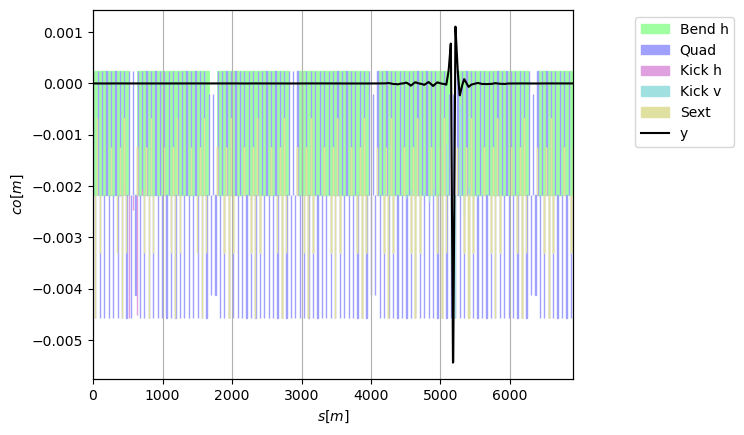

In [217]:
twn.plot('x')
twn.plot('y')
plt.show()

## Make tcsm and tidp aperture bigger

In [218]:
env = line.env

env.elements['tidp.11434.a_aper'] = xt.LimitEllipse(a=0.1, b=0.1)
env.elements['tidp.11434.b_aper'] = xt.LimitEllipse(a=0.1, b=0.1)

env.elements['tcsm.51932.a_aper'] = xt.LimitEllipse(a=0.1, b=0.1)
env.elements['tcsm.51932.b_aper'] = xt.LimitEllipse(a=0.1, b=0.1)


In [219]:
line.to_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

# Collimator tests

In [248]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [223]:
tt.rows['.*bp.*'].name

array(['bpv.10108.a_aper', 'bpv.10108', 'bpv.10108.b_aper',
       'bph.10208.a_aper', 'bph.10208', 'bph.10208.b_aper',
       'bpv.10308.a_aper', 'bpv.10308', 'bpv.10308.b_aper',
       'bph.10408.a_aper', 'bph.10408', 'bph.10408.b_aper',
       'bpv.10508.a_aper', 'bpv.10508', 'bpv.10508.b_aper',
       'bph.10608.a_aper', 'bph.10608', 'bph.10608.b_aper',
       'bpv.10708.a_aper', 'bpv.10708', 'bpv.10708.b_aper',
       'bph.10808.a_aper', 'bph.10808', 'bph.10808.b_aper',
       'bpv.10908.a_aper', 'bpv.10908', 'bpv.10908.b_aper',
       'bph.11008.a_aper', 'bph.11008', 'bph.11008.b_aper',
       'bpv.11108.a_aper', 'bpv.11108', 'bpv.11108.b_aper',
       'bph.11208.a_aper', 'bph.11208', 'bph.11208.b_aper',
       'bpv.11308.a_aper', 'bpv.11308', 'bpv.11308.b_aper',
       'bph.11408.a_aper', 'bph.11408', 'bph.11408.b_aper',
       'bpv.11508.a_aper', 'bpv.11508', 'bpv.11508.b_aper',
       'bph.11608.a_aper', 'bph.11608', 'bph.11608.b_aper',
       'bpv.11706.a_aper', 'bpv.11706', 

In [126]:
tt.rows['bpcn.12508.*']

Table: 3 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
bpcn.12508.a_aper        799.59 LimitEllipse   False     False None               False
bpcn.12508              799.708 Drift           True     False None               False
bpcn.12508.b_aper       799.825 LimitEllipse   False     False None               False

In [127]:
import apertls

In [224]:
ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()

In [225]:
mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))

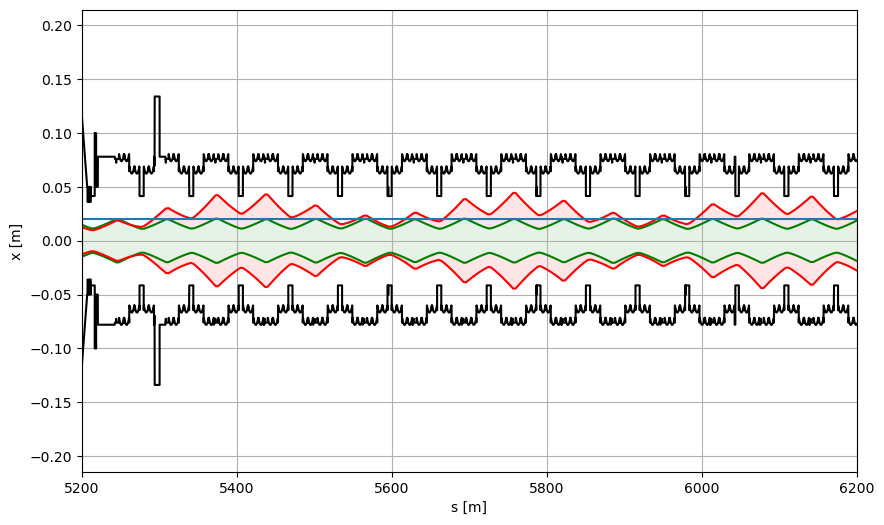

In [226]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
n_buckets = 1

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], color='k')
ax.plot(tt.s[mask], x_ext[:, 1], color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
# ax.legend()
ax.set_xlim(5200,6200)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.hlines(0.02, 5200, 6200)
# plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

In [227]:
np.min(x_ext[:,1])

np.float64(0.0315)

In [228]:
tt.name[mask][np.argmin(x_ext[:,1])]

'vvgst.61737.a_aper'

In [229]:
line['bpcn.12508.a_aper']

View of LimitEllipse(a=0.038, b=0.038)

In [249]:
n_buckets = 2
mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
mask_bpm = ['bp' in name for name in tt.name]
mask_aper = np.array(['aper' in name for name in tt.name])

In [250]:
len(tt.name[mask_disp & mask_bpm & ~mask_aper])

146

In [251]:
offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
colls = []
for nn in offmom_bpms:
    #remove aperture
    if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
        jaw = line[nn+'.a_aper'].a
    else:
        jaw = line[nn+'.a_aper'].max_x
        
    line.remove(nn+'.a_aper')
    line.remove(nn+'.b_aper')

    #add collimator
    colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))

In [252]:
line.collimators.install(names=offmom_bpms, elements=colls)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [253]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [254]:
tidp = install_tidp(line, block_mvt=29e-3)
tcsm = install_tcsm(line)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

## Off-momentum lossmap

In [255]:
context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

In [256]:
num_particles  = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [257]:
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=3.5e-6, nemitt_y=3.5e-6)

In [258]:
#Particles
x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))
y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(num_particles)))

X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
x_norm = X.ravel()
y_norm = Y.ravel()

px_norm = np.zeros_like(x_norm)
py_norm = np.zeros_like(x_norm)
zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
delta = np.ones_like(x_norm)*tw.particle_on_co.delta

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=3.5e-6, nemitt_y=3.5e-6, zeta=zeta, delta=delta)

In [259]:
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# Track during RF sweep:
line.scattering.enable()
line.track(particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Done sweeping RF in 519.6s.


In [260]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=False)

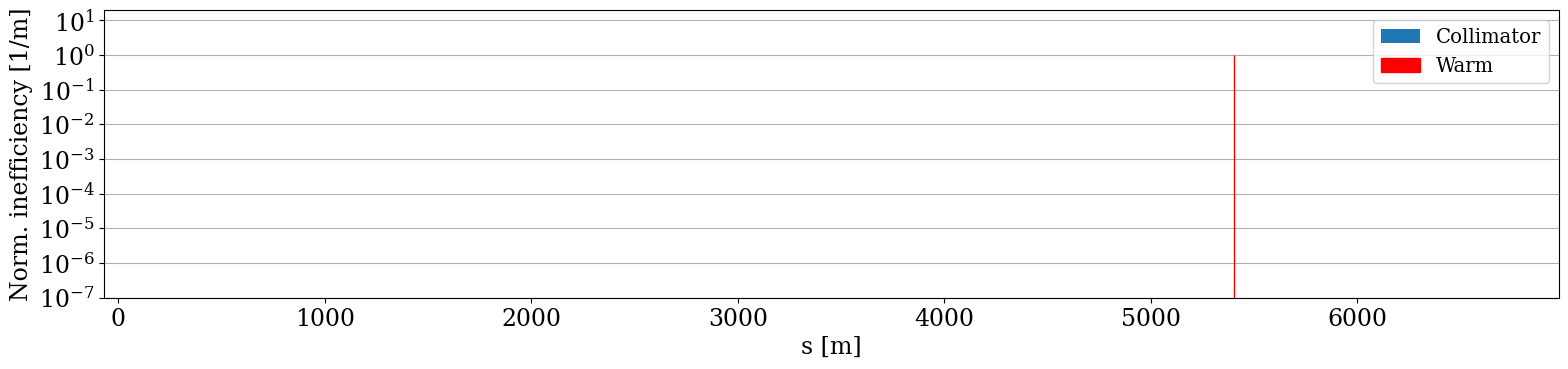

In [261]:
fig, ax =ThisLM.plot()

In [263]:
part.at_element

array([25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137, 25137,
       25137, 25137,

In [265]:
line.element_names[25137]

'vcak.52501.a_aper'

# General collimator script

In [2]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

In [3]:
def make_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    return tidp

def make_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    return tcsm

In [15]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [16]:
# Install collimators
n_buckets = 2
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
mask_bpm = ['bp' in name for name in tt.name]
mask_aper = np.array(['aper' in name for name in tt.name])

offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
colls = []
for nn in offmom_bpms:
    #remove aperture
    if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
        jaw = line[nn+'.a_aper'].a
    else:
        jaw = line[nn+'.a_aper'].max_x
        
    line.remove(nn+'.a_aper')
    line.remove(nn+'.b_aper')

    #add collimator
    colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))

line.collimators.install(names=offmom_bpms, elements=colls)
line.collimators.open()
tidp = install_tidp(line, block_mvt=29e-3)
# impacts = xc.InteractionRecord.start(line=line)

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

In [17]:
context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

In [18]:
num_particles  = 1000
plane = 'DPneg'
sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000
nemitt_x=2e-6
nemitt_y=2e-6

In [19]:
tw = line.twiss()
tt = line.get_table()
line.collimators.assign_optics(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

In [ ]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2809114751256145


In [21]:
rf_sweep = xc.RFSweep(line)
rf_sweep.prepare(sweep_per_turn=sweep/num_turns)
rf_sweep.info()

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# Track during RF sweep:
line.scattering.enable()
line.track(particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Enabled time-dependent variables in the line.
The current frequency is 200000001.0Hz, adding 1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = -2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.0 turns.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Done sweeping RF in 454.5s.


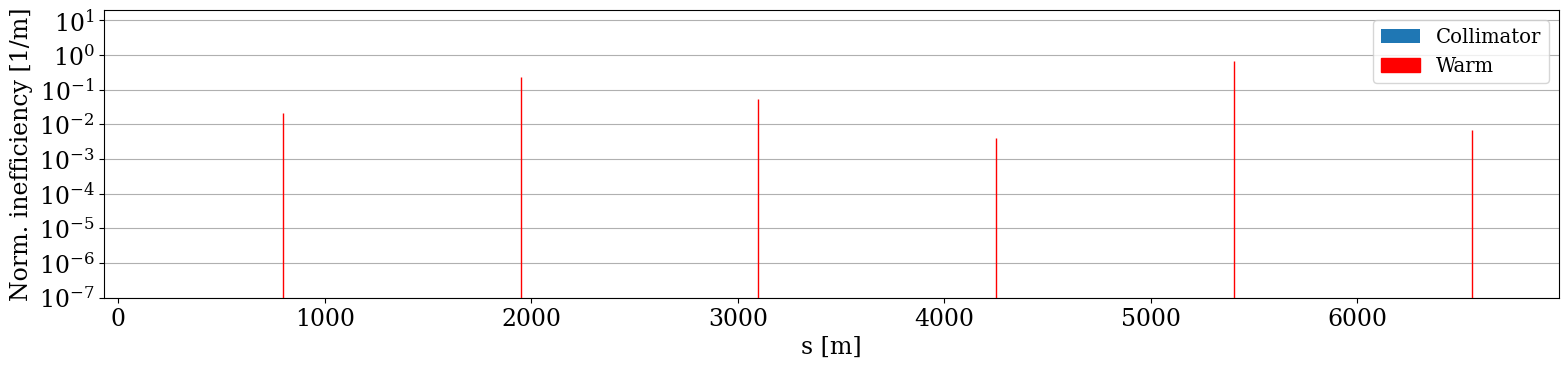

In [22]:
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=False)
fig, ax = ThisLM.plot()

In [25]:
np.unique(part.state, return_counts=True)

(array([0, 1]), array([993,   7]))

In [27]:
idxs, c = np.unique(part.at_element, return_counts=True)

In [29]:
for idx in idxs:
    print(f"{line.element_names[idx]}: {c[np.where(idxs==idx)[0][0]]}")

sps$start: 7
vcak.12501.a_aper: 21
vcak.22501.a_aper: 230
vcak.32501.a_aper: 55
vcak.42501.a_aper: 4
vcak.52501.a_aper: 676
vcak.62501.a_aper: 7
